In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import preprocess

In [166]:
data = pd.read_csv('data/caspecoTrainingData.csv')


In [167]:

sales, _ = preprocess(data, fill_dates=True, norm_by='month')
sales

# 2020-01-01. 0
# 2020-03-10  1
# 2020-03-23. 2
# 2020-07-02. 3
# 2020-11-03. 4
# 2020-12-22. 5
# 2021-03-01. 6
# 2021-07-15. 4
# 2021-09-29. 1
# 2021-12-23. 3
# 2022-02-09. 1
# 2022-03-29. 0
# restriction grades above, set dates after
"""
sales['Restriction'] = 0
sales['Restriction'] = np.where(sales['Date'] > '2020-03-10', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-03-23', 2, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-07-02', 3, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-11-03', 4, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2020-12-22', 5, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-03-01', 6, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-07-15', 4, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-09-29', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2021-12-23', 3, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2022-02-09', 1, sales['Restriction'])
sales['Restriction'] = np.where(sales['Date'] > '2022-03-29', 0, sales['Restriction'])

"""

{0: array([620487.06151161]), 1: array([896135.53119759]), 2: array([5468590.99734427])}


"\nsales['Restriction'] = 0\nsales['Restriction'] = np.where(sales['Date'] > '2020-03-10', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-03-23', 2, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-07-02', 3, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-11-03', 4, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2020-12-22', 5, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-03-01', 6, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-07-15', 4, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-09-29', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2021-12-23', 3, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2022-02-09', 1, sales['Restriction'])\nsales['Restriction'] = np.where(sales['Date'] > '2022-03-29', 0, sales['Restriction'])\n\n"

In [168]:
sales['Season'] = sales['Date'].dt.quarter
X = sales.drop(['Date','Sales','Year', 'Workday', 'Payweek', 'Day', 'Month'], axis=1)
X = pd.get_dummies(X, columns=['Weekday', 'Season', 'Week'])
y = sales['Sales']
X_split = [X[X['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]]
y_split = [sales[sales['Company'] == i]['Sales'] for i in [0,1,2]]

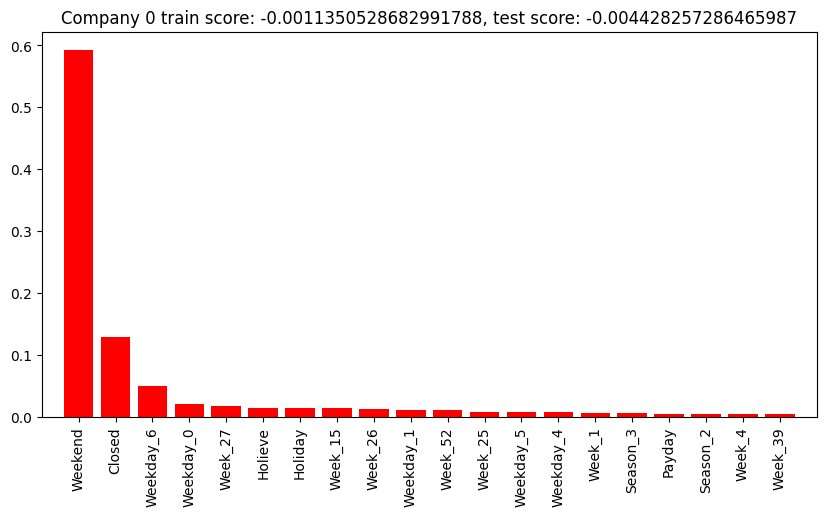

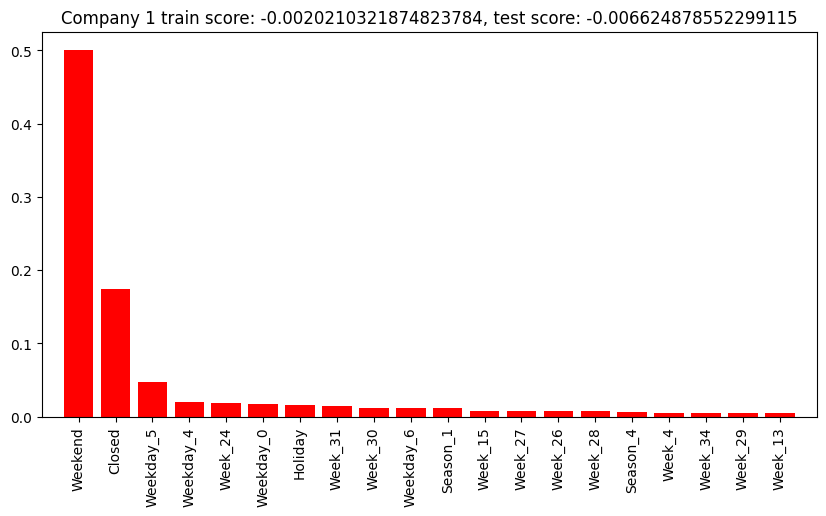

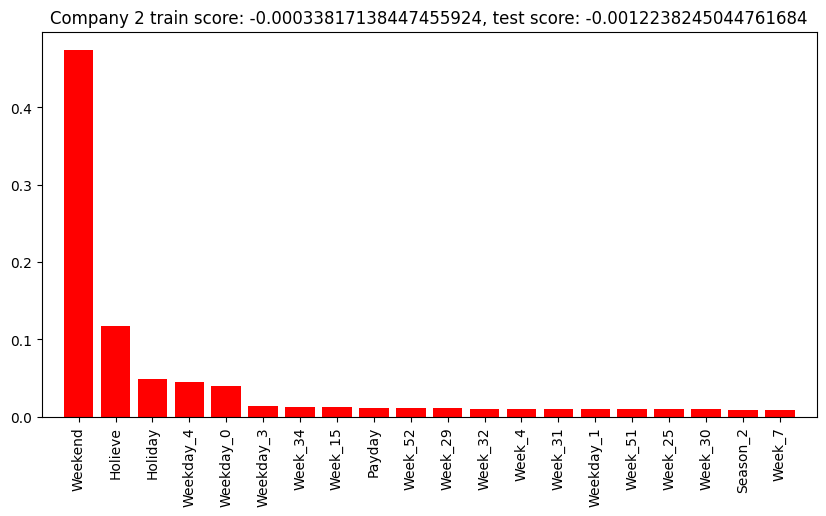

In [169]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

estimators = {}

# add params for random forest

for X_i, y_i, company in zip(X_split, y_split, [0, 1, 2]):
    cv = cross_validate(ExtraTreesRegressor(n_estimators=500), X_i, y_i,
                        scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)
    # take mean of feature importances from all 5 models
    feature_importances = np.mean([est.feature_importances_ for est in cv['estimator']], axis=0)
    # sort by importance
    indices = np.argsort(feature_importances)[::-1]
    estimators[company] = cv['estimator'][np.argmin(cv['test_score'])]
    # plot 20 most important features
    plt.figure(figsize=(10, 5))
    plt.title(
        f"Company {company} train score: {np.mean(cv['train_score'])}, test score: {np.mean(cv['test_score'])}")
    plt.bar(range(20), feature_importances[indices][:20], color="r", align="center")
    plt.xticks(range(20), X_i.columns[indices][:20], rotation=90)
    plt.xlim([-1, 20])
    plt.show()
    

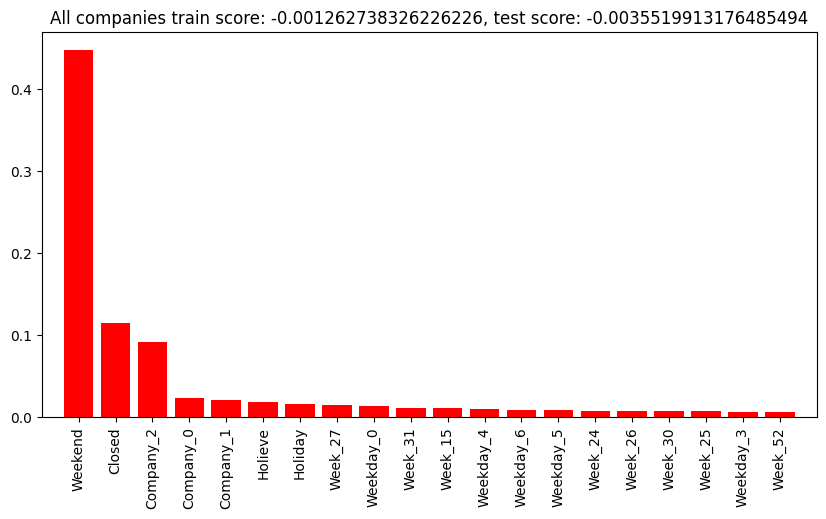

In [170]:
X_comp = pd.get_dummies(X, columns=['Company'])

cv = cross_validate(RandomForestRegressor(n_estimators=500), X_comp, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)
feature_importances = np.mean([est.feature_importances_ for est in cv['estimator']], axis=0)
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title(
    f"All companies train score: {np.mean(cv['train_score'])}, test score: {np.mean(cv['test_score'])}")
plt.bar(range(20), feature_importances[indices][:20], color="r", align="center")
plt.xticks(range(20), X_comp.columns[indices][:20], rotation=90)
plt.xlim([-1, 20])
plt.show()

In [171]:
# data sales from 09
actual_data = preprocess(data, fill_dates=True)
validation = actual_data[actual_data['Date'] >= '2022-11-01']


In [172]:
validation_sales = validation['Sales']
validation['Season'] = validation['Date'].dt.quarter
X_valid = validation.drop(
    ['Date', 'Sales', 'Year', 'Month', 'Workday', 'Payweek', 'Day'], axis=1)
X_valid = pd.get_dummies(X_valid, columns=['Weekday', 'Week', 'Season'])
# fill with missing columns form X
for col in X.columns:
  if col not in X_valid.columns:
    X_valid[col] = 0
X_valid_dict = {i: X_valid[X_valid['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]}
X_valid_dict['all'] = pd.get_dummies(X_valid, columns=['Company'])

predicitions = validation[['Date', 'Company']]
predicitions['Pred_company'] = 0
for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(X_valid_dict[company])
  predicitions[predicitions['Company'] == company] = company_df

predicitions['Pred_all'] = cv['estimator'][np.argmin(cv['test_score'])].predict(X_valid_dict['all'])

/tmp/ipykernel_13297/1420808412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Season'] = validation['Date'].dt.quarter
/tmp/ipykernel_13297/1420808412.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicitions['Pred_company'] = 0
/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in 

In [173]:
predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)

for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_company'].sum()
  company_df.loc[:, 'Pred_all'] = company_df['Pred_all'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_all'].sum()
  company_df.loc[:, 'Pred_mean'] = company_df['Pred_mean'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_mean'].sum()
  predicitions[predicitions['Company'] == company] = company_df

/tmp/ipykernel_13297/2693500436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)
/tmp/ipykernel_13297/2693500436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * validation[validation['Company'] == company]['Sales'].sum() / company_df['Pred_company'].sum()
/tmp/ipykernel_13297/2693500436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy

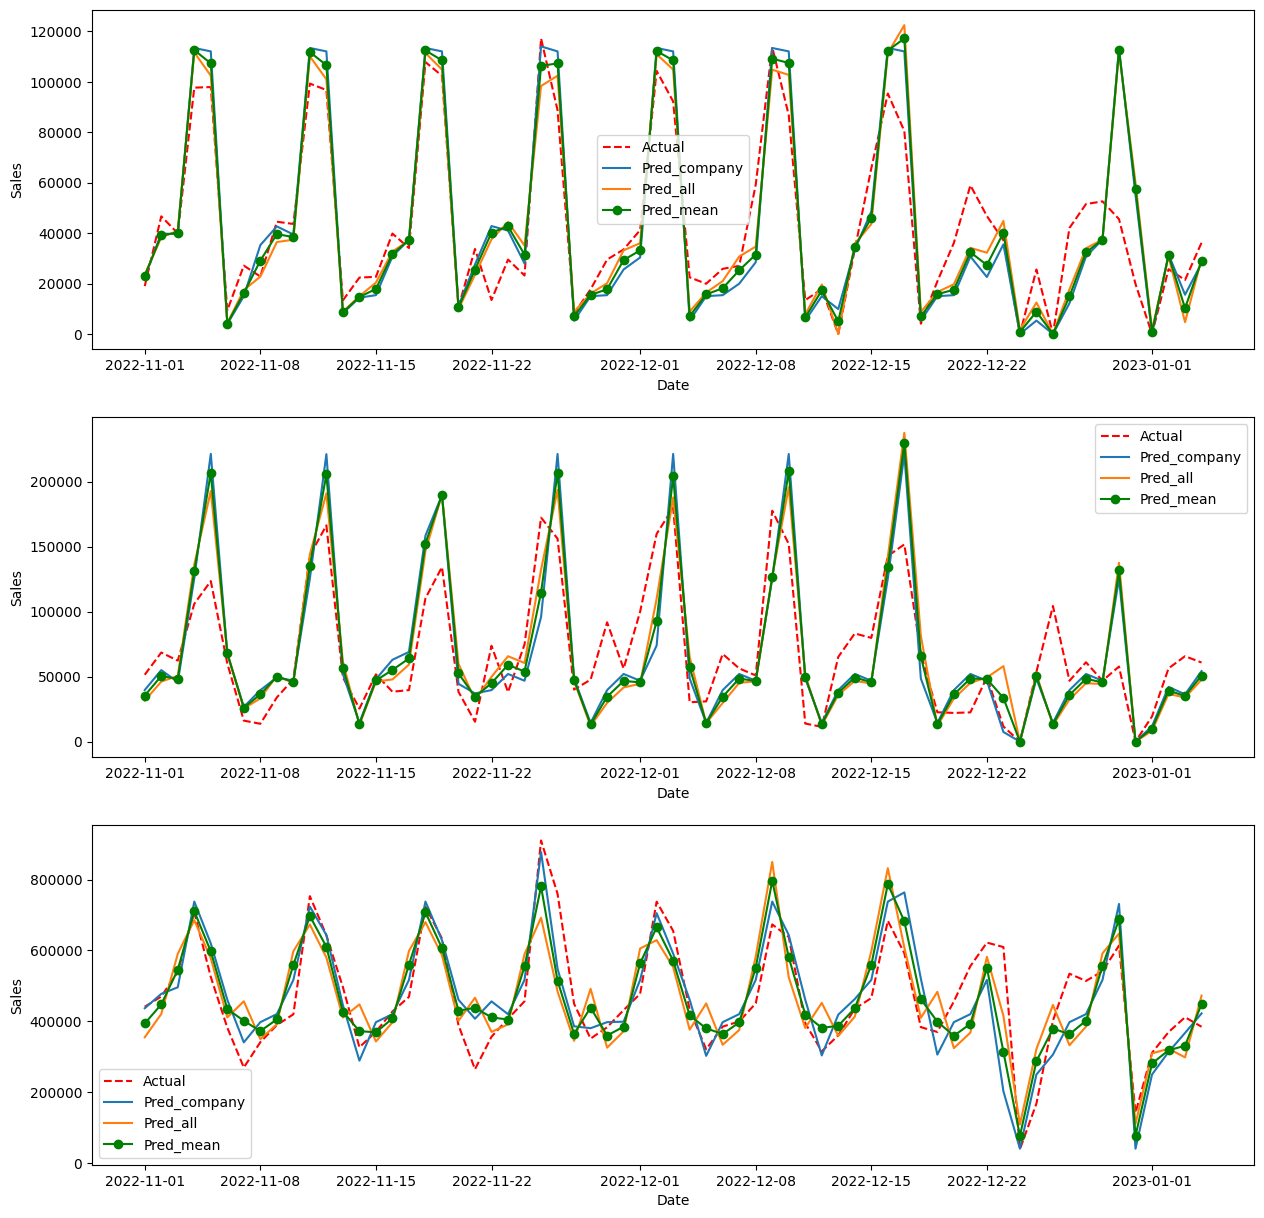

In [174]:
# plot all predictions per company
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for company in [0,1,2]:
  x = predicitions[predicitions['Company'] == company]['Date']
  actual = validation_sales[validation['Company'] == company]
  pred_company = predicitions[predicitions['Company'] == company]['Pred_company']
  pred_all = predicitions[predicitions['Company'] == company]['Pred_all']
  pred_mean = predicitions[predicitions['Company'] == company]['Pred_mean']
  ax[company].plot(x, actual, 'r--',  label='Actual')
  ax[company].plot(x, pred_company, label='Pred_company')
  ax[company].plot(x, pred_all, label='Pred_all')
  ax[company].plot(x, pred_mean, 'g-o', label='Pred_mean')
  ax[company].legend()
  ax[company].set_xlabel('Date')
  ax[company].set_ylabel('Sales')


In [175]:
actual_data = preprocess(data, fill_dates=True)


/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/tmp/ipykernel_13297/1465976390.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(to_predict_dict[company])
/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn

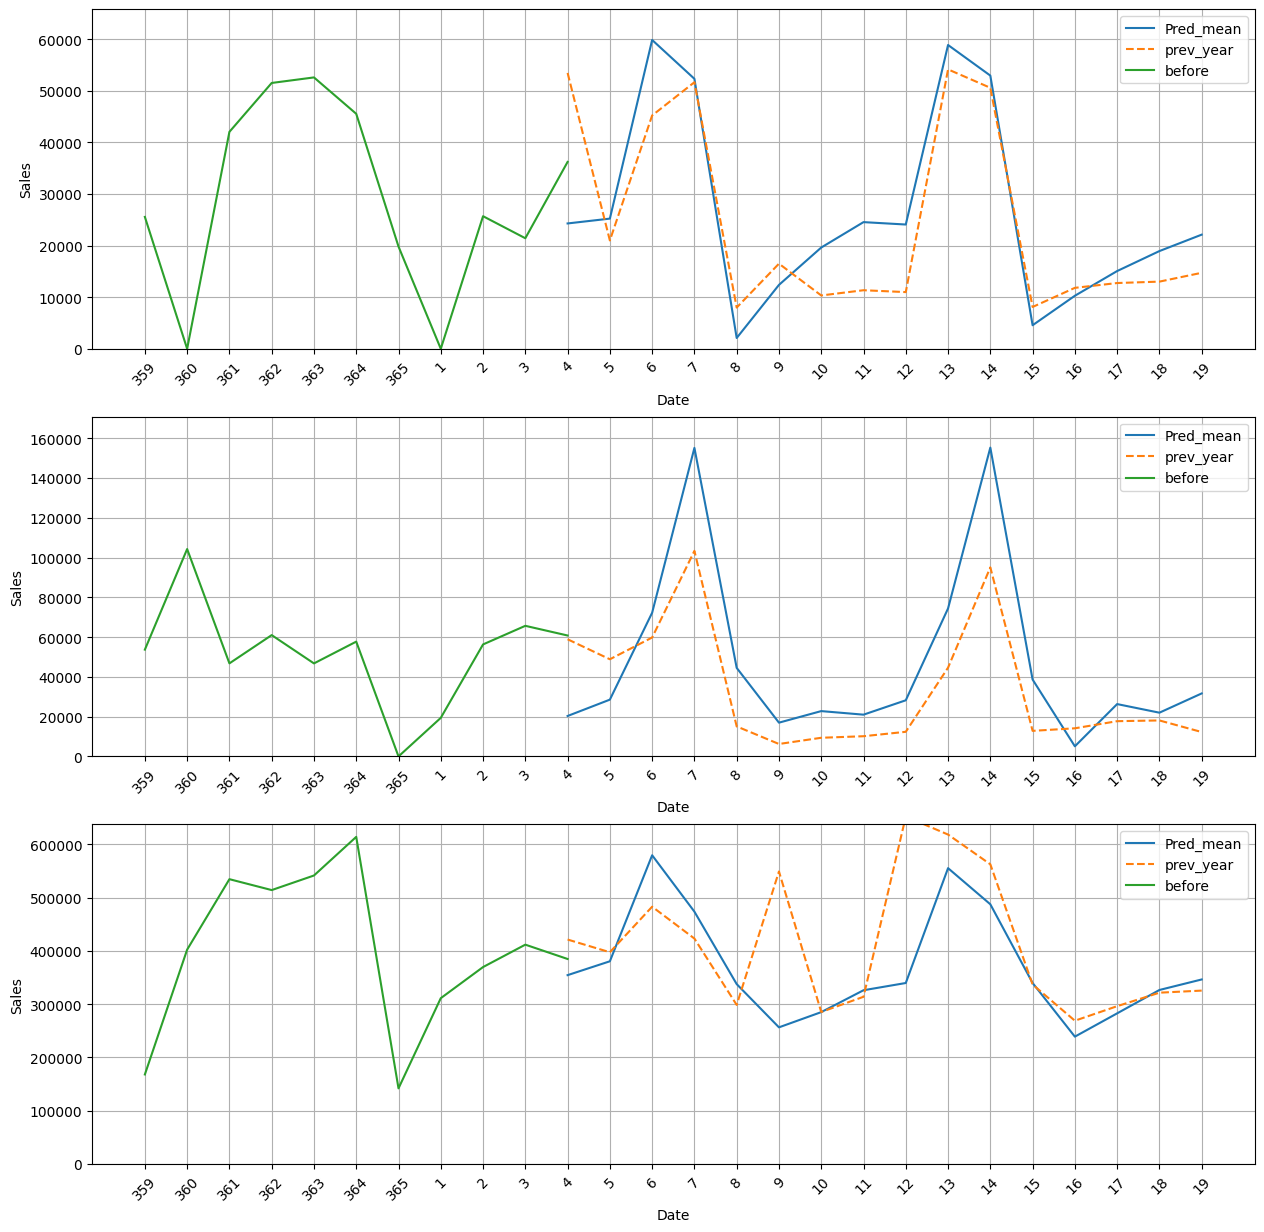

In [206]:
new_dates = pd.date_range("2023-01-04", "2023-01-19")
to_predict = pd.DataFrame({'Date': new_dates.repeat(3), 'Company': np.tile([0,1,2], len(new_dates)), 'Sales': 0})
to_predict.head()
to_predict = preprocess(to_predict, fill_dates=False)
to_predict['Season'] = to_predict['Date'].dt.quarter
#X = sales.drop(['Date','Sales','Year', 'Workday', 'Payweek', 'Day', 'Month'], axis=1)
#X = pd.get_dummies(X, columns=['Weekday', 'Season', 'Week'])
to_predict = to_predict.drop(
    ['Date', 'Sales', 'Year', 'Workday', 'Payweek', 'Day', 'Month'], axis=1)
to_predict = pd.get_dummies(to_predict, columns=['Weekday', 'Season', 'Week'])
# add columns missing from X
for col in X.columns:
  if col not in to_predict.columns:
    to_predict[col] = 0

to_predict_dict = {i: to_predict[to_predict['Company'] == i].drop(['Company'], axis=1) for i in [0,1,2]}
to_predict_dict['all'] = pd.get_dummies(to_predict, columns=['Company'])

predicitions = pd.DataFrame({'Date': new_dates.repeat(3), 'Company': np.tile([0, 1, 2], len(new_dates))})
predicitions['Pred_company'] = 0
for company in [0,1,2]:
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = estimators[company].predict(to_predict_dict[company])
  predicitions[predicitions['Company'] == company] = company_df

predicitions['Pred_all'] = cv['estimator'][np.argmin(cv['test_score'])].predict(to_predict_dict['all'])

predicitions['Pred_mean'] = predicitions[['Pred_company', 'Pred_all']].mean(axis=1)

for company in [0,1,2]:
  scale = validation_sales[validation['Company'] == company][-12:].mean()
  company_df = predicitions[predicitions['Company'] == company]
  company_df.loc[:, 'Pred_company'] = company_df['Pred_company'] * scale / company_df['Pred_company'].mean()
  company_df.loc[:, 'Pred_all'] = company_df['Pred_all'] * scale / company_df['Pred_all'].mean()
  company_df.loc[:, 'Pred_mean'] = company_df['Pred_mean'] * scale / company_df['Pred_mean'].mean()
  predicitions[predicitions['Company'] == company] = company_df

# plot all predictions per company
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for company in [0,1,2]:
  x = pd.date_range("2022-12-25", "2023-01-19")
  pred_company = predicitions[predicitions['Company'] == company]['Pred_company']
  pred_all = predicitions[predicitions['Company'] == company]['Pred_all']
  pred_mean = predicitions[predicitions['Company'] == company]['Pred_mean']
  prev_year = actual_data[(actual_data['Company'] == company) & (
      actual_data['Date'] >= '2022-01-05') & (actual_data['Date'] <= '2022-01-20')]['Sales']
  # pad start for pred_company, pred_all, pred_mean and prev_year with zeros to match length of x

  before = actual_data[(actual_data['Company'] == company) & (
      actual_data['Date'] <= '2023-01-04') & (actual_data['Date'] >= '2022-12-25')]['Sales']
  
  # set ax xticks to x
  ax[company].set_xticks(x)
  ax[company].set_xticklabels(x.day_of_year, rotation=45)
  #ax[company].plot(x, pred_company, label='Pred_company')
  #ax[company].plot(x, pred_all, label='Pred_all')
  ax[company].plot(x[10:], pred_mean, label='Pred_mean')
  ax[company].plot(x[10:], prev_year, '--', label='prev_year')
  ax[company].plot(x[:11], before, label='before')
  ax[company].grid()
  ax[company].legend()
  ax[company].set_xlabel('Date')
  ax[company].set_ylabel('Sales')
  ax[company].set_ylim(0, max(pred_mean) * 1.1)

In [192]:
# create an output dataframe with columns ID and Sales, where prediction['Date', 'Company'] is ID as YYYY-MM-DD_company and Sales is the prediction['Pred_mean']
output = pd.DataFrame({'ID': predicitions['Date'].astype(str) + '_' + predicitions['Company'].astype(str), 'Sales': predicitions['Pred_mean']})
output.to_csv('submission.csv', index=False)